<a href="https://colab.research.google.com/github/sayakpaul/Revisiting-Pooling-in-CNNs/blob/main/SoftPool.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook implements the **SoftPool** layer as proposed in the [Refining activation downsampling with SoftPool](https://arxiv.org/pdf/2101.00440.pdf) paper by Stergiou et al. We will also see how to use its 2D variant inside a shallow CNN and train the network. We will be using the **Flowers dataset** for this purpose. Finally, to examine the information loss between the pooled outputs and the original inputs we will compare SoftPool to the popular pooling methods w.r.t SSI (Structual Similarity Index) just as the original paper. 

## Initial Setup

In [ ]:
!nvidia-smi

Wed Jan 27 04:13:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8    10W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
tf.random.set_seed(666)
print(tf.__version__)

2.4.0


In [ ]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from skimage.metrics import structural_similarity as ssim
from scipy.special import softmax
import matplotlib.pyplot as plt
import numpy as np
import time

## Collect and prepare Flowers dataset

In [ ]:
# Gather Flowers dataset
training_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 128

@tf.function
def resize_image(image, label):
    image = tf.image.resize(image, (180, 180)) 
    return (image, label)

training_ds = (
    training_ds
    .shuffle(1024)
    .map(resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

validation_ds = (
    validation_ds
    .map(resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

**Note** that for extremely low resolution datasets like MNIST, FashionMNIST, CIFAR10 SoftPool's inclusion may not be that significant. 

## Implementing SoftPool with for loops

In order to understand SoftPool better, let's implement the main idea of SoftPool with `numpy` and for loops. Here's a visual from the paper as well - 

<center>
<img src="https://i.ibb.co/RB4T1vB/image.png"></img>
</center>

In [ ]:
# Reference: 
# https://towardsdatascience.com/building-convolutional-neural-network-using-numpy-from-scratch-b30aac50e50a
def soft_pooling(feature_map, size=2, stride=2):
    pool_out = np.zeros((int(np.ceil((feature_map.shape[0]-size+1)/stride)),
                            int(np.ceil((feature_map.shape[1]-size+1)/stride)),
                            feature_map.shape[-1]), dtype=np.float32)
    for map_num in range(feature_map.shape[-1]):
        r2 = 0
        for r in np.arange(0,feature_map.shape[0]-size-1, stride):
            c2 = 0
            for c in np.arange(0, feature_map.shape[1]-size-1, stride):
                activation_weights = softmax(feature_map[r:r+size, c:c+size, map_num])
                pool_out[r2, c2, map_num] = np.sum(activation_weights * feature_map[r:r+size, c:c+size, map_num])
                c2 = c2 + 1
            r2 = r2 +1
    return pool_out

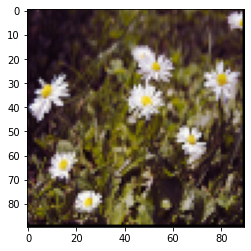

In [ ]:
# Apply the `soft_pooling` method on a single image
batch_images, _ = next(iter(training_ds))
single_image = batch_images.numpy()[0]
pooled_output = soft_pooling(single_image/255.)
plt.imshow(pooled_output)
plt.show()

## Comparison to AveragePooling and MaxPooling

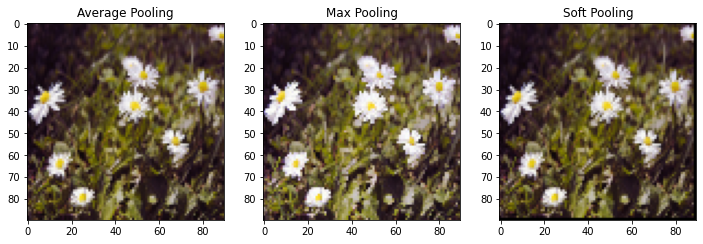

In [ ]:
single_image_tf = tf.convert_to_tensor(single_image/255.)
single_image_tf = tf.expand_dims(single_image_tf, 0)
avg_pool = tf.keras.layers.AveragePooling2D(padding="same")(single_image_tf)
max_pool = tf.keras.layers.MaxPool2D(padding="same")(single_image_tf)

plt.figure(figsize=(12, 12))

plt.subplot(1, 3, 1)
plt.imshow(tf.squeeze(avg_pool, 0))
plt.title("Average Pooling")

plt.subplot(1, 3, 2)
plt.imshow(tf.squeeze(max_pool, 0))
plt.title("Max Pooling")

plt.subplot(1, 3, 3)
plt.imshow(pooled_output)
plt.title("Soft Pooling")

plt.show()

## Implementing as a standalone layer in Keras

In [ ]:
# Reference:
# https://github.com/qwopqwop200/SoftPool/blob/main/tensorflow_softpool.py#L14-#L22
class SoftPooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=(2, 2),strides=None,padding='valid',data_format=None):
        super(SoftPooling2D, self).__init__()
        self.avgpool = tf.keras.layers.AvgPool2D(pool_size,strides,padding,data_format)
    def call(self, x):
        x_exp = tf.math.exp(x)
        x_exp_pool = self.avgpool(x_exp)
        x = self.avgpool(x_exp*x)
        return x/x_exp_pool

Please note that the equations of SoftPool have been reformulated above to obtain an optimized implementation. All the pooling hyperparameters are set to their default values. 

## Shallow CNN utility

In [ ]:
# Reference:
# https://www.tensorflow.org/tutorials/load_data/images
def get_model(pool_type=tf.keras.layers.MaxPooling2D):
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        pool_type(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        pool_type(),
        tf.keras.layers.Conv2D(32, 3, activation='relu'),
        pool_type(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(5)
    ])
    model.compile(optimizer='adam', 
                  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

## Other utilities

In [ ]:
def plot_training(H):
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

In [ ]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

## Training with Max Pooling

**Note** that accuracy is not important here. 

Epoch 1/40
25/25 [==============================] - 9s 224ms/step - loss: 1.5873 - accuracy: 0.2365 - val_loss: 1.4817 - val_accuracy: 0.3873
Epoch 2/40
25/25 [==============================] - 3s 117ms/step - loss: 1.4300 - accuracy: 0.3779 - val_loss: 1.2787 - val_accuracy: 0.4600
Epoch 3/40
25/25 [==============================] - 3s 118ms/step - loss: 1.2656 - accuracy: 0.4334 - val_loss: 1.1817 - val_accuracy: 0.5127
Epoch 4/40
25/25 [==============================] - 3s 117ms/step - loss: 1.1847 - accuracy: 0.4971 - val_loss: 1.1430 - val_accuracy: 0.5218
Epoch 5/40
25/25 [==============================] - 3s 117ms/step - loss: 1.1628 - accuracy: 0.5223 - val_loss: 1.1333 - val_accuracy: 0.5327
Epoch 6/40
25/25 [==============================] - 3s 117ms/step - loss: 1.1053 - accuracy: 0.5531 - val_loss: 1.0666 - val_accuracy: 0.5782
Epoch 7/40
25/25 [==============================] - 3s 117ms/step - loss: 1.0867 - accuracy: 0.5734 - val_loss: 1.0731 - val_accuracy: 0.5291
Epoch 

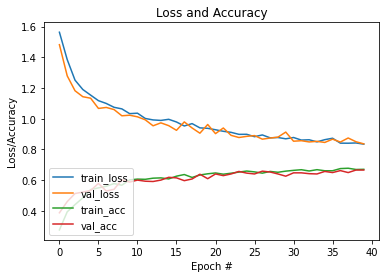

5/5 [==============================] - 0s 49ms/step - loss: 0.8359 - accuracy: 0.6655
Final test accuracy: 66.545%


In [ ]:
max_pool_model = get_model()
start = time.time()
history = max_pool_model.fit(training_ds,
                             validation_data=validation_ds,
                             epochs=40,
                             callbacks=[es])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(history)
acc = max_pool_model.evaluate(validation_ds)[1]
print("Final test accuracy: {:.3f}%".format(acc*100))

## Training with Average Pooling

Epoch 1/40
25/25 [==============================] - 3s 116ms/step - loss: 1.5944 - accuracy: 0.2592 - val_loss: 1.5225 - val_accuracy: 0.3418
Epoch 2/40
25/25 [==============================] - 3s 110ms/step - loss: 1.4626 - accuracy: 0.3891 - val_loss: 1.3407 - val_accuracy: 0.3873
Epoch 3/40
25/25 [==============================] - 3s 110ms/step - loss: 1.3213 - accuracy: 0.4106 - val_loss: 1.2402 - val_accuracy: 0.4673
Epoch 4/40
25/25 [==============================] - 3s 110ms/step - loss: 1.2523 - accuracy: 0.4364 - val_loss: 1.2163 - val_accuracy: 0.4655
Epoch 5/40
25/25 [==============================] - 3s 112ms/step - loss: 1.2300 - accuracy: 0.4670 - val_loss: 1.1858 - val_accuracy: 0.4873
Epoch 6/40
25/25 [==============================] - 3s 111ms/step - loss: 1.2187 - accuracy: 0.4772 - val_loss: 1.1803 - val_accuracy: 0.4909
Epoch 7/40
25/25 [==============================] - 3s 110ms/step - loss: 1.2149 - accuracy: 0.4821 - val_loss: 1.1691 - val_accuracy: 0.5000
Epoch 

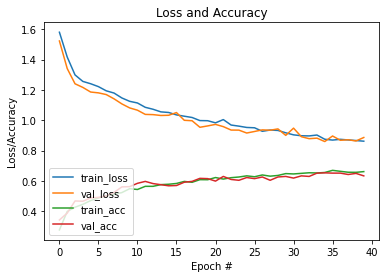

5/5 [==============================] - 0s 47ms/step - loss: 0.8592 - accuracy: 0.6527
Final test accuracy: 65.273%


In [ ]:
# Softpooling
avg_pool_model = get_model(pool_type=tf.keras.layers.AveragePooling2D)
start = time.time()
history = avg_pool_model.fit(training_ds,
                             validation_data=validation_ds,
                             epochs=40,
                             callbacks=[es])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(history)
acc = avg_pool_model.evaluate(validation_ds)[1]
print("Final test accuracy: {:.3f}%".format(acc*100))

## Training with SoftPooling

Epoch 1/40
25/25 [==============================] - 6s 232ms/step - loss: 1.5996 - accuracy: 0.2479 - val_loss: 1.5447 - val_accuracy: 0.3782
Epoch 2/40
25/25 [==============================] - 6s 227ms/step - loss: 1.4925 - accuracy: 0.3699 - val_loss: 1.3175 - val_accuracy: 0.3891
Epoch 3/40
25/25 [==============================] - 6s 227ms/step - loss: 1.3261 - accuracy: 0.4064 - val_loss: 1.2322 - val_accuracy: 0.4418
Epoch 4/40
25/25 [==============================] - 6s 229ms/step - loss: 1.2535 - accuracy: 0.4254 - val_loss: 1.1903 - val_accuracy: 0.4727
Epoch 5/40
25/25 [==============================] - 6s 228ms/step - loss: 1.2248 - accuracy: 0.4637 - val_loss: 1.1940 - val_accuracy: 0.4964
Epoch 6/40
25/25 [==============================] - 6s 228ms/step - loss: 1.1992 - accuracy: 0.4868 - val_loss: 1.1463 - val_accuracy: 0.5127
Epoch 7/40
25/25 [==============================] - 6s 227ms/step - loss: 1.1727 - accuracy: 0.5047 - val_loss: 1.1272 - val_accuracy: 0.5164
Epoch 

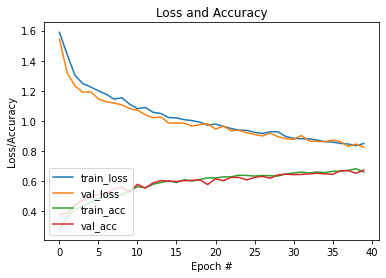

5/5 [==============================] - 0s 57ms/step - loss: 0.8258 - accuracy: 0.6745
Final test accuracy: 67.455%


In [ ]:
# Softpooling
soft_pool_model = get_model(pool_type=SoftPooling2D)
start = time.time()
history = soft_pool_model.fit(training_ds,
                             validation_data=validation_ds,
                             epochs=40,
                             callbacks=[es])
end = time.time()
print("Network takes {:.3f} seconds to train".format(end - start))
plot_training(history)
acc = soft_pool_model.evaluate(validation_ds)[1]
print("Final test accuracy: {:.3f}%".format(acc*100))

## Evaluating information loss with SSI

As noted in the paper, the accuracy gains with SoftPool might not be very significant with respect to the existing pooling methods but the main motivation behind using SoftPool is to reduce the information loss induced due downsampling. In order to quantitatively evaluate this, the authors of SoftPool do the following (along with two other similarity measures) - 

> Structural Similarity Index (SSI) is a widely-used similarity measure between two images, in our case the original and downsampled image. The SSI is based on the computation of a luminance term, a contrast term and a structural term. Larger index values correspond to larger structural similarities between the images compared.

^ This text is taken from **Section 4.2** of the paper. 

In [ ]:
# Reference:
# https://scikit-image.org/docs/dev/auto_examples/transform/plot_ssim.html
def get_ssi(images, pool_type=tf.keras.layers.MaxPool2D):
    pooled_images = pool_type()(images)
    resize_images = tf.image.resize(images, (pooled_images.shape[1], pooled_images.shape[2]))
    ssims = []
    
    for i in range(len(pooled_images)):
        pooled_image = pooled_images[i].numpy()
        min_range, max_range = np.min(pooled_image), np.max(pooled_image)
        ssim_one = ssim(resize_images[i].numpy(), pooled_image, data_range=max_range - min_range,
                        multichannel=True)
        ssims.append(ssim_one)

    return ssims

In [ ]:
# Sample images 
sample_images = batch_images[:10]/255.

# MaxPooling
max_pool_ssim = get_ssi(sample_images)

# AveragePooling
avg_pool_ssim = get_ssi(sample_images, tf.keras.layers.AveragePooling2D)

# SoftPooling
soft_pool_ssim = get_ssi(sample_images, SoftPooling2D)

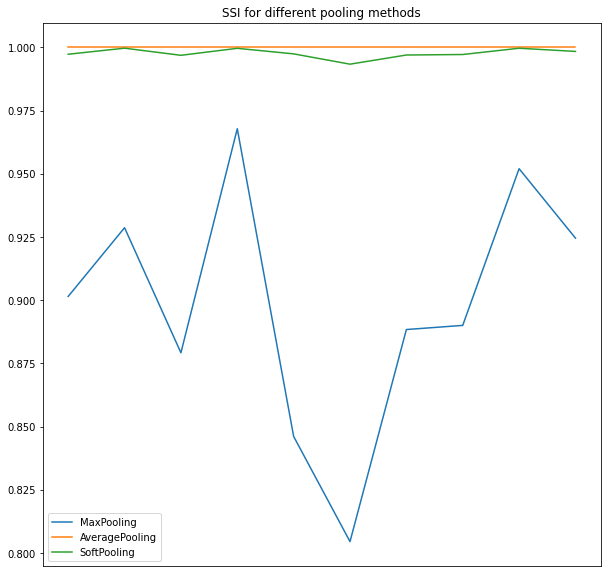

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(max_pool_ssim, label="MaxPooling")
plt.plot(avg_pool_ssim, label="AveragePooling")
plt.plot(soft_pool_ssim, label="SoftPooling")
plt.title("SSI for different pooling methods")
plt.xticks([])
plt.legend(loc="lower left")
plt.show()

Please keep in mind that we are evaluating these techniques on a small dataset that has sampling bias and it indeed affects the results. Also note that the objective of this notebook is to help the reader with simple walkthroughs of the techniques and recipes discussed in the original paper. 

## Acknowledgements

Thanks to Alexandros Stergiou for all the help. 